In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, Callback

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
train_dir = '/kaggle/input/weed-detection-in-crop-fields/data/train'
test_dir = '/kaggle/input/weed-detection-in-crop-fields/data/test'

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1e-5

In [3]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 833 images belonging to 2 classes.
Found 207 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [4]:
# Feature Extraction with MobileNetV2
# base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Feature Extraction with VGG16
# base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
# Feature Extraction with ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

def extract_features(generator, feature_extractor):
    features, labels = [], []
    for inputs, targets in generator:
        features.append(feature_extractor.predict(inputs))
        labels.append(targets)
        if len(features) >= len(generator):
            break
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(val_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)

train_features_flat = train_features.reshape(train_features.shape[0], -1)
val_features_flat = val_features.reshape(val_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

I0000 00:00:1733481121.573319    7543 service.cc:145] XLA service 0x7bc2d014e700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733481121.573365    7543 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733481121.573369    7543 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1733481125.511974    7543 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━

In [8]:
# Custom callback to log learning rate and loss
class LearningRateLossLogger(Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lrs.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs.get('loss'))

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    return lr * 0.95  # Reduce learning rate by 5% each epoch

lr_logger = LearningRateLossLogger()
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

In [9]:
# custom callback for Precision, Recall, and F1-Score vs Epochs
class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.precisions = []
        self.recalls = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = (self.model.predict(val_generator) > 0.5).astype(int).flatten()
        val_labels = val_generator.classes

        precision = precision_score(val_labels, val_predictions)
        recall = recall_score(val_labels, val_predictions)
        f1 = f1_score(val_labels, val_predictions)

        self.precisions.append(precision)
        self.recalls.append(recall)
        self.f1_scores.append(f1)

# Train model with the custom metrics logger
metrics_logger = MetricsLogger()

In [10]:
# Build and Fine-Tune End-to-End Classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Initial training
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Fine-tune
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
fine_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_logger, metrics_logger, lr_scheduler_callback]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - accuracy: 0.5178 - loss: 0.7353 - val_accuracy: 0.5314 - val_loss: 0.6587
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5574 - loss: 0.6986 - val_accuracy: 0.7874 - val_loss: 0.5879
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.5940 - loss: 0.6625 - val_accuracy: 0.7681 - val_loss: 0.5603
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6157 - loss: 0.6558 - val_accuracy: 0.8261 - val_loss: 0.5293
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.6694 - loss: 0.6103 - val_accuracy: 0.7729 - val_loss: 0.5193
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.6603 - loss: 0.6102 - val_accuracy: 0.8213 - val_loss: 0.4989
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.7068 - loss: 0.5781 - val_accuracy: 0.6763 - val_loss: 0.5260
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.6427 - loss: 0.6215 - val_accuracy: 0.8454 - val

I0000 00:00:1733481417.363316    7543 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 20 bytes spill stores, 20 bytes spill loads



12/27 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.5708 - loss: 7.0759  

I0000 00:00:1733481439.357639    7543 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_22', 20 bytes spill stores, 20 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 547ms/steptep - accuracy: 0.5928 - los
27/27 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.5948 - loss: 6.2895 - val_accuracy: 0.5121 - val_loss: 1.1023 - learning_rate: 9.5000e-06
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step ep - accuracy: 0.8434 - l
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.8438 - loss: 1.8203 - val_accuracy: 0.4879 - val_loss: 11.8099 - learning_rate: 9.0250e-06
Epoch 3/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step ep - accuracy: 0.8923 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.8921 - loss: 1.4335 - val_accuracy: 0.4879 - val_loss: 27.8839 - learning_rate: 8.5737e-06
Epoch 4/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/stepep - accuracy: 0.9202 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.9203 - loss: 1.0139 - val_accuracy: 0.4879 - val_loss: 47.4869 - learning_rate: 8.1451e-06
Epoch 5/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/stepep - accuracy: 0.9345 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.9347 - loss: 0.6893 - val_accuracy: 0.4879 - val_loss: 84.1246 - learning_rate: 7.7378e-06
Epoch 6/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step ep - accuracy: 0.9365 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - accuracy: 0.9366 - loss: 0.5824 - val_accuracy: 0.4879 - val_loss: 120.2679 - learning_rate: 7.3509e-06
Epoch 7/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step ep - accuracy: 0.9444 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.9444 - loss: 0.5229 - val_accuracy: 0.4879 - val_loss: 144.3222 - learning_rate: 6.9834e-06
Epoch 8/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step ep - accuracy: 0.9261 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 339ms/step - accuracy: 0.9267 - loss: 0.8769 - val_accuracy: 0.4879 - val_loss: 161.8221 - learning_rate: 6.6342e-06
Epoch 9/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/stepep - accuracy: 0.9496 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.9500 - loss: 0.4918 - val_accuracy: 0.4879 - val_loss: 171.1953 - learning_rate: 6.3025e-06
Epoch 10/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step ep - accuracy: 0.9702 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9701 - loss: 0.2263 - val_accuracy: 0.4879 - val_loss: 177.8013 - learning_rate: 5.9874e-06
Epoch 11/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/stepep - accuracy: 0.9588 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.9587 - loss: 0.3770 - val_accuracy: 0.4879 - val_loss: 187.8102 - learning_rate: 5.6880e-06
Epoch 12/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step ep - accuracy: 0.9707 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.9707 - loss: 0.1704 - val_accuracy: 0.4879 - val_loss: 190.0247 - learning_rate: 5.4036e-06
Epoch 13/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step ep - accuracy: 0.9626 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9628 - loss: 0.3037 - val_accuracy: 0.4879 - val_loss: 188.5852 - learning_rate: 5.1334e-06
Epoch 14/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step ep - accuracy: 0.9705 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9705 - loss: 0.2203 - val_accuracy: 0.4879 - val_loss: 185.6992 - learning_rate: 4.8767e-06
Epoch 15/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step ep - accuracy: 0.9778 - lo
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9776 - loss: 0.1253 - val_accuracy: 0.4879 - val_loss: 187.2734 - learning_rate: 4.6329e-06
Epoch 16/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step ep - accuracy: 0.9785 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9786 - loss: 0.1368 - val_accuracy: 0.4879 - val_loss: 194.1209 - learning_rate: 4.4013e-06
Epoch 17/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step ep - accuracy: 0.9680 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9683 - loss: 0.2509 - val_accuracy: 0.4879 - val_loss: 194.1652 - learning_rate: 4.1812e-06
Epoch 18/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step ep - accuracy: 0.9925 - l
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9919 - loss: 0.0781 - val_accuracy: 0.4879 - val_loss: 195.6868 - learning_rate: 3.9721e-06
Epoch 19/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step ep - accuracy: 0.9573 - los
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9577 - loss: 0.3959 - val_accuracy: 0.4879 - val_loss: 194.8300 - learning_rate: 3.7735e-06
Epoch 20/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step ep - accuracy: 0.9808 - los
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.9809 - loss: 0.1901 - val_accuracy: 0.4879 - val_loss: 183.3958 - learning_rate: 3.5849e-06
Epoch 21/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step ep - accuracy: 0.9833 - los
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 337ms/step - accuracy: 0.9830 - loss: 0.1371 - val_accuracy: 0.4879 - val_loss: 168.3177 - learning_rate: 3.4056e-06
Epoch 22/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step ep - accuracy: 0.9856 - lo
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9856 - loss: 0.0820 - val_accuracy: 0.4879 - val_loss: 152.9592 - learning_rate: 3.2353e-06
Epoch 23/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step ep - accuracy: 0.9851 - los
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9850 - loss: 0.1609 - val_accuracy: 0.4879 - val_loss: 133.0175 - learning_rate: 3.0736e-06
Epoch 24/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step ep - accuracy: 0.9733 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9733 - loss: 0.2176 - val_accuracy: 0.4879 - val_loss: 117.0804 - learning_rate: 2.9199e-06
Epoch 25/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step ep - accuracy: 0.9703 - l
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.9706 - loss: 0.1864 - val_accuracy: 0.4879 - val_loss: 99.0053 - learning_rate: 2.7739e-06
Epoch 26/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step ep - accuracy: 0.9798 - 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9799 - loss: 0.1870 - val_accuracy: 0.4879 - val_loss: 81.7750 - learning_rate: 2.6352e-06
Epoch 27/50


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step ep - accuracy: 0.9780 - l
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.9782 - loss: 0.1206 - val_accuracy: 0.4928 - val_loss: 66.4261 - learning_rate: 2.5034e-06
Epoch 28/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step ep - accuracy: 0.9887 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.9887 - loss: 0.0664 - val_accuracy: 0.4976 - val_loss: 54.4820 - learning_rate: 2.3783e-06
Epoch 29/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step ep - accuracy: 0.9799 - loss
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.9800 - loss: 0.1060 - val_accuracy: 0.4976 - val_loss: 42.8900 - learning_rate: 2.2594e-06
Epoch 30/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/stepep - accuracy: 0.9810 
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 345ms/step - accuracy: 0.9809 - loss: 0.1168 - val_accuracy: 0.5121 - val_loss: 34.1618 - learning_rate: 2.1464e-06
Epoch 31/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step ep - accuracy: 0.9915 -
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accu

In [11]:
# Classifiers
classifiers = {
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

for name, clf in classifiers.items():
    clf.fit(train_features_flat, train_labels)

In [12]:
def evaluate(clf, X, y_true, is_keras_model=False):
    if is_keras_model:
        y_pred = (clf.predict(X) > 0.5).astype(int).flatten()
        y_proba = clf.predict(X).flatten()
    else:
        y_pred = clf.predict(X)
        y_proba = clf.predict_proba(X)[:, 1] if hasattr(clf, "predict_proba") else None

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    return accuracy, precision, recall, f1, auc


In [13]:

# Evaluate classifiers
true_labels = test_generator.classes
for name, clf in classifiers.items():
    print(f"\n{name} Performance:")
    metrics = evaluate(clf, test_features_flat, true_labels)
    print(f"Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, "
          f"F1: {metrics[3]:.4f}, AUC: {metrics[4]:.4f}")

# Evaluate Model
metrics = evaluate(model, test_generator, true_labels, is_keras_model=True)
print("\nModel Performance:")
print(f"Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, "
      f"F1: {metrics[3]:.4f}, AUC: {metrics[4]:.4f}")


SVM Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       127
           1       0.83      0.90      0.87       133

    accuracy                           0.86       260
   macro avg       0.86      0.86      0.86       260
weighted avg       0.86      0.86      0.86       260

Accuracy: 0.8577, Precision: 0.8333, Recall: 0.9023, F1: 0.8664, AUC: 0.9357

Logistic Regression Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       127
           1       0.89      0.92      0.91       133

    accuracy                           0.90       260
   macro avg       0.90      0.90      0.90       260
weighted avg       0.90      0.90      0.90       260

Accuracy: 0.9038, Precision: 0.8913, Recall: 0.9248, F1: 0.9077, AUC: 0.9703

Random Forest Performance:

Classification Report:
              precision    recall  f1-sc

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       127
           1       0.98      0.97      0.97       133

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260


Model Performance:
Accuracy: 0.9731, Precision: 0.9773, Recall: 0.9699, F1: 0.9736, AUC: 0.9846


In [14]:
# Visualization

# Plot Training vs Validation Accuracy and Loss
def plot_training(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# ROC Curve
def plot_auc_roc(y_true, y_proba, title="AUC-ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=test_generator.class_indices.keys(), 
                yticklabels=test_generator.class_indices.keys())
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to plot Precision-Recall Curve
def plot_precision_recall(y_true, y_proba, title="Precision vs Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    avg_precision = average_precision_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}', color='purple')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Plot Learning Rate vs Loss
def plot_LR(title="Learning Rate vs Loss"):
    plt.figure(figsize=(8, 6))
    plt.plot(lr_logger.lrs, lr_logger.losses, marker='o', color='purple')
    plt.title(title)
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.xscale('log')
    plt.grid()
    plt.show()

# Plot Precision, Recall, and F1-Score vs Epochs
def plot_metrices_epochs(title="Precision, Recall, and F1-Score vs Epochs"):
    plt.figure(figsize=(8, 6))
    epochs_range = range(1, EPOCHS + 1)
    plt.plot(epochs_range, metrics_logger.precisions, label='Precision', color='blue')
    plt.plot(epochs_range, metrics_logger.recalls, label='Recall', color='green')
    plt.plot(epochs_range, metrics_logger.f1_scores, label='F1-Score', color='red')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()

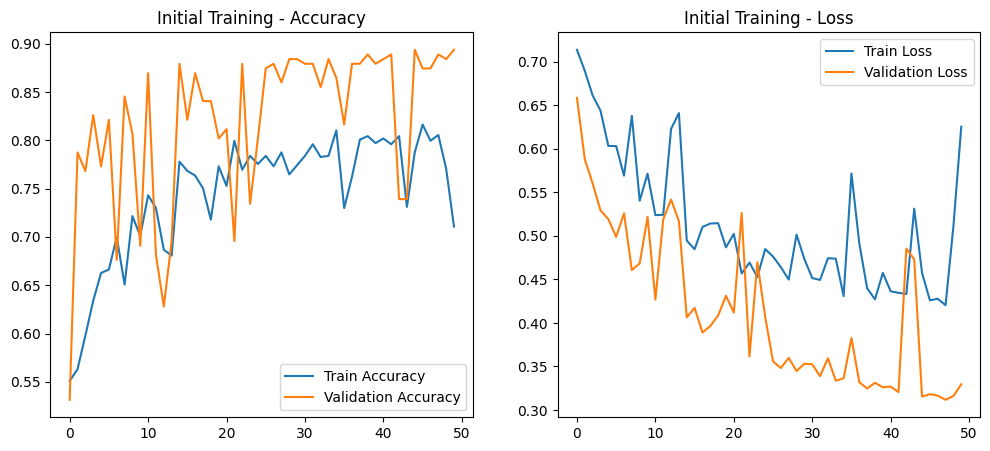

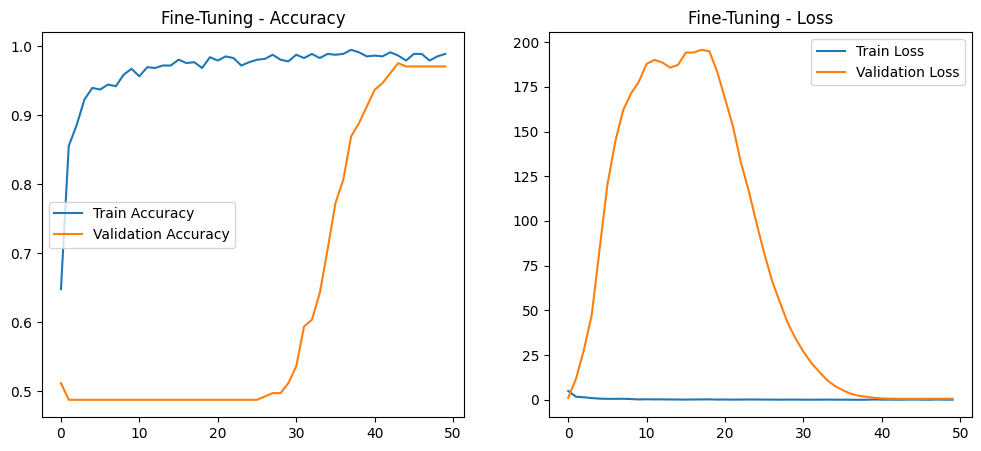

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


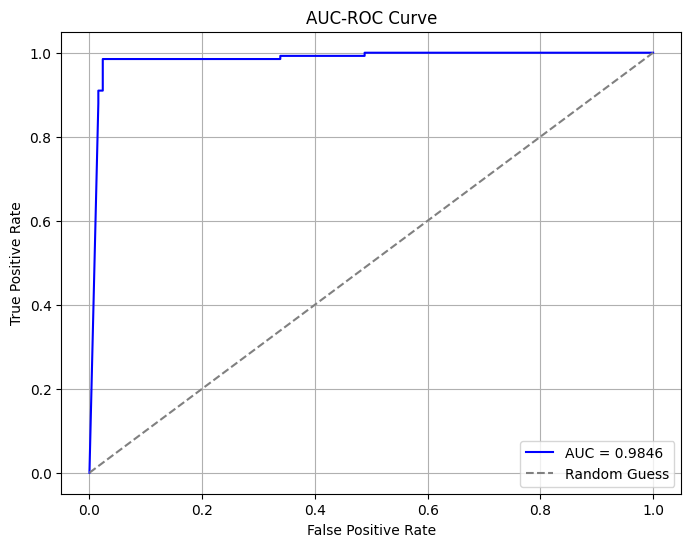

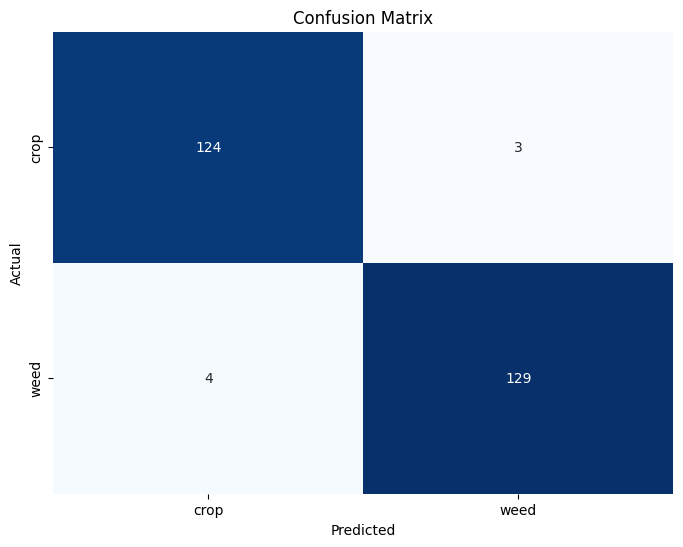

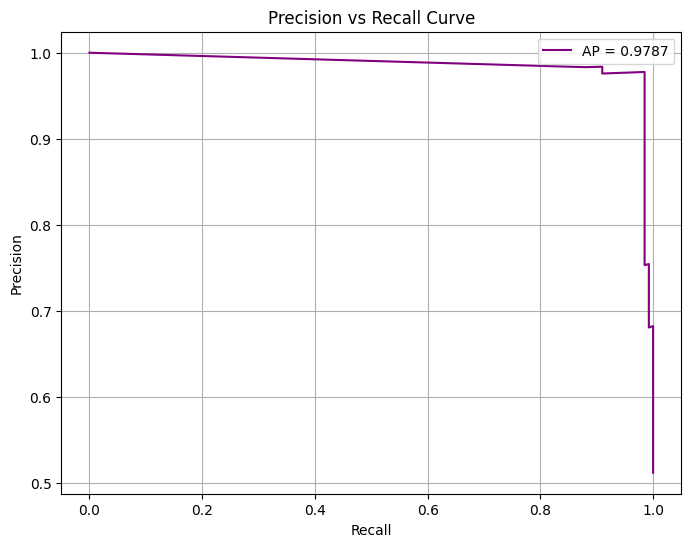

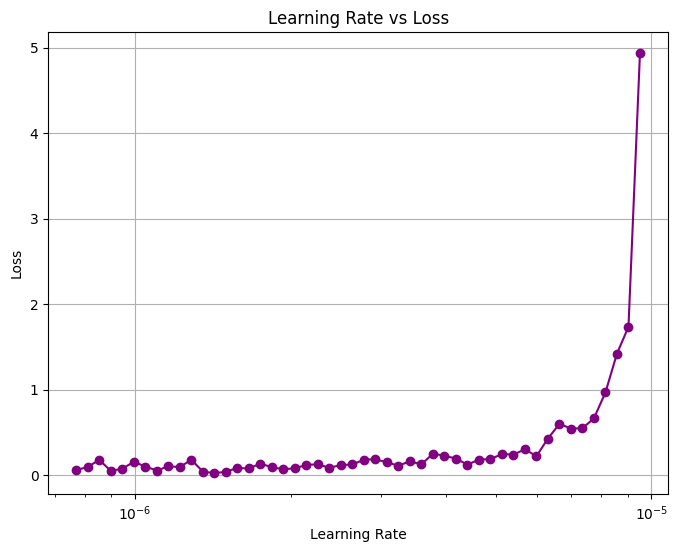

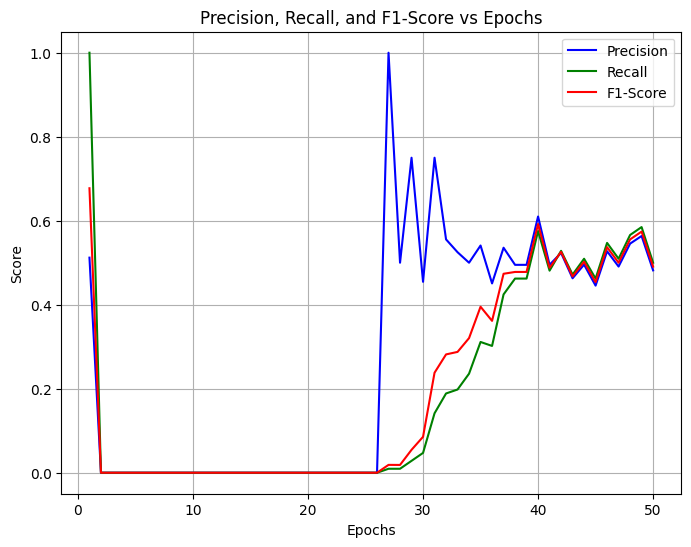

In [15]:
# Training vs Validation Accuracy and Loss
plot_training(history, "Initial Training")
plot_training(fine_history, "Fine-Tuning")

# Generate and visualize results
y_proba = model.predict(test_generator).flatten()
y_pred = (y_proba > 0.5).astype(int)

# ROC Curve and AUC
plot_auc_roc(true_labels, y_proba)

# Confusion Matrix
plot_confusion_matrix(true_labels, y_pred)

# Precision-Recall Curve
plot_precision_recall(true_labels, y_proba)

# Learning Rate vs Loss
plot_LR()

# Precision, Recall, and F1-Score vs Epochs
plot_metrices_epochs()